In [1]:
#import libraries
import numpy as np
import geopandas as gpd
import shapely 
import matplotlib.pyplot as plt
import os
#import seaborn as sns
import pandas as pd
import sklearn

C:\Users\Thinkpad\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# user should replace with their directory
data_dir = os.environ.get('DATA_DIR', )

csv_path = os.path.join(data_dir, 'cook_county_gdf_intro_quarterly.csv')
cook_county_gdf = pd.read_csv(csv_path) 

In [3]:
cook_county_gdf.year.isna().sum()

56

In [4]:
#add in missing 58 tracts
cook_county_gdf['quarter'].fillna(9999, inplace=True)
cook_county_gdf['year'].fillna(9999, inplace=True)

In [5]:
cook_county_gdf.loc[cook_county_gdf['year'] == 9999, 'geoid'].nunique()

56

In [6]:
columns_to_keep = [
    'INTPTLAT', 'INTPTLON', 
    'STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
    'geometry']

gdf_quarter = cook_county_gdf.groupby(['geoid', 'quarter', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

### Making DF square - one quarter for each tract


In [7]:
gdf_quarter.loc[gdf_quarter['year'] == 9999, 'deaths'] = 0
gdf_quarter.loc[gdf_quarter['quarter'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_quarter['year'].replace(9999, 2015, inplace=True)
gdf_quarter['quarter'].replace(9999, 1, inplace=True)

In [8]:
gdf_quarter['geoid'].nunique()  #1332

1332

In [9]:
# Fill in missing tract-year-period cells
# Warning: Nested for loops

years = range(2015, 2024)
quarters = range(1, 5)

existing_combinations = set(zip(gdf_quarter['geoid'], gdf_quarter['year'], gdf_quarter['quarter']))
updated_rows = []

for tract in gdf_quarter['geoid'].unique():
    for year in years:
        for quarter in quarters:
            combination = (tract, year, quarter)
            if combination not in existing_combinations:
                new_row = {'geoid': tract, 'year': year, 'quarter': quarter, 'deaths': 0}
                updated_rows.append(new_row)

gdf_quarter = pd.concat([gdf_quarter, pd.DataFrame(updated_rows)], ignore_index=True)


In [10]:
#fills in NAs produced from above
unique_tracts = gdf_quarter['geoid'].unique()

for tract in unique_tracts:
    tract_rows = gdf_quarter[gdf_quarter['geoid'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_quarter.loc[(gdf_quarter['geoid'] == tract) & gdf_quarter[column].isna(), column] = non_na_row[column]

In [11]:
gdf_quarter.shape #should be (48148, 16)


(48148, 16)

In [12]:
gdf_quarter['geoid'].nunique()  #should be 1332

1332

In [13]:
#confirms all years and quarters present

years = range(2015, 2023)  # data collect started in late '14, we ran this notebook in mid '23
quarters = range(1, 5)  

for geoid in gdf_quarter['geoid'].unique():
    for year in years:
        for quarter in quarters:
            if not ((gdf_quarter['geoid'] == geoid) & (gdf_quarter['year'] == year) & (gdf_quarter['quarter'] == quarter)).any():
                print("Missing row for geoid {} in year {} quarter {}".format(geoid, year, quarter))



In [14]:
#Any NAs in data frame?

has_na = gdf_quarter.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [15]:
#Any Duplicates?
has_duplicates = gdf_quarter.duplicated().any()

if has_duplicates:
    print("There are duplicate rows in the dataframe.")
else:
    print("There are no duplicate rows in the dataframe.")


There are no duplicate rows in the dataframe.


In [16]:
#change format of year and quarters

gdf_quarter['year'] = pd.to_datetime(gdf_quarter['year'].astype(int).astype(str), format='%Y').dt.year
gdf_quarter['quarter'] = gdf_quarter['quarter'].astype(str).replace('1.0', '1').replace('2.0', '2').replace('3.0', '3').replace('4.0', '4')


In [17]:
gdf_quarter.columns

Index(['geoid', 'quarter', 'year', 'deaths', 'INTPTLAT', 'INTPTLON', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'geometry'],
      dtype='object')

In [18]:
#take out 2014 and 2023
gdf_quarter = gdf_quarter[gdf_quarter['year'] != 2023]
gdf_quarter = gdf_quarter[gdf_quarter['year'] != 2014]

In [19]:
sorted(gdf_quarter.year.unique())

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [20]:
# Create timestep column
gdf_quarter = gdf_quarter.sort_values(by=['geoid', 'year', 'quarter']).reset_index(drop=True).copy()

gdf_quarter['semiannual'] = gdf_quarter['quarter'].astype(np.int32).map(lambda x: 1 if x <= 2 else 2)

# Group the data by 'geoid' and use 'cumcount' to create the 'timestep' column.
gdf_quarter['timestep'] = gdf_quarter.groupby('geoid').cumcount() + 1

# Create season column
def map_season(q):
    if q == 1:
        return 'jan-mar'
    elif q == 2:
        return 'apr-jun'
    elif q == 3:
        return 'jul-sep'
    elif q == 4:
        return 'oct-dec'
gdf_quarter['season'] = gdf_quarter['quarter'].map(map_season)

In [21]:
# Create 'year_frac' column that indicates timeperiod in fractional years
gdf_quarter['year_frac'] = gdf_quarter['year'].values + (gdf_quarter['quarter'].values.astype('int') - 1)/4

In [22]:
gdf_quarter.columns

Index(['geoid', 'quarter', 'year', 'deaths', 'INTPTLAT', 'INTPTLON', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'geometry', 'semiannual', 'timestep', 'season', 'year_frac'],
      dtype='object')

In [23]:
# REORDER columns to be easier for humans to inspect
gdf_quarter = gdf_quarter[[
    'geoid', 'timestep', 'year_frac', 
    'deaths',
    'year', 'semiannual', 'quarter', 'season']
    + columns_to_keep
    ].copy()


In [24]:
#convert back to gdf
from shapely import wkt

gdf_quarter['geometry'] = gdf_quarter['geometry'].apply(wkt.loads)

gdf_quarter = gpd.GeoDataFrame(gdf_quarter, geometry='geometry')
gdf_quarter.crs = {'init': 'EPSG:4269'}
type(gdf_quarter)

C:\Users\Thinkpad\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

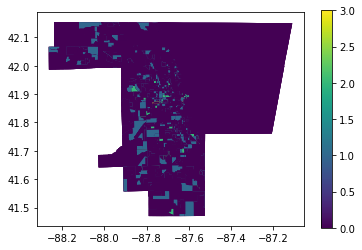

In [25]:
gdf_quarter[gdf_quarter['year']==2015].plot('deaths', legend=True)


### store gdf

In [26]:
gdf_quarter.to_csv(csv_path.replace("intro", "clean"), index=False)